## Modelado Proyecto Oil & Gas 

In [1]:
#Importacion y configuracion
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib


# Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Métricas y Validación
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import (
    accuracy_score, recall_score, f1_score, roc_auc_score, 
    confusion_matrix, classification_report, roc_curve, auc
)
from sklearn.decomposition import PCA

#importar utils 
import sys
import os

sys.path.append(os.path.abspath(".."))
from utils.eval_tools import evaluar_modelo, evaluar_overfitting


# Configuración de Gráficos
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Carga de datos
print('Cargando datos procesados...')

X_train = pd.read_csv('../data/X_train_processed.csv')
X_test = pd.read_csv('../data/X_test_processed.csv')

y_train = pd.read_csv('../data/y_train.csv')
y_test = pd.read_csv('../data/y_test.csv')

# Nombre de las features
try:
    feature_names = joblib.load('../data/model_columns.pkl')
    # Chequeo de seguridad:
    if len(feature_names) == X_train.shape[1]:
        print("Nombres de features verificados con el pickle.")
    else:
        print("Diferencia en features. Usando headers del CSV.")
        feature_names = list(X_train.columns)
except:
    feature_names = list(X_train.columns)

print(f"Dimensiones Train: {X_train.shape}")
print(f"Dimensiones Test:  {X_test.shape}")
print(f"Features: {len(feature_names)}")

Cargando datos procesados...
Dimensiones Train: (800, 16)
Dimensiones Test:  (200, 16)
Features: 16


### Entrenamiento Individual de Modelos


Entrenando Baseline (Logistic Regression)...

EVALUACIÓN: Logistic Regression
Accuracy:  0.9200
Recall:    0.9615
F1-Score:  0.9494
ROC-AUC:   0.9656


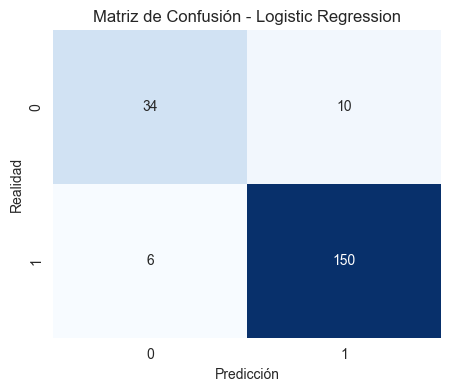

In [3]:
# Definicion de Modelos y Métricas

# Diccionario para guardar resultados finales
resultados  = []

#Baseline: Regresion Logistica 
print("\nEntrenando Baseline (Logistic Regression)...")

lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)

resultados_lr = evaluar_modelo(lr_model, 
                                X_test, 
                                y_test,
                                'Logistic Regression')

resultados.append(resultados_lr)


Entrenando Random Forest...



EVALUACIÓN: Random Forest
Accuracy:  0.9350
Recall:    0.9744
F1-Score:  0.9590
ROC-AUC:   0.9851


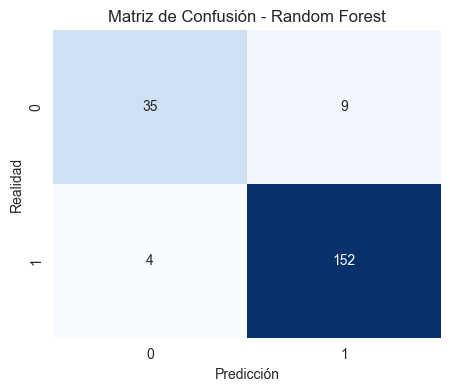

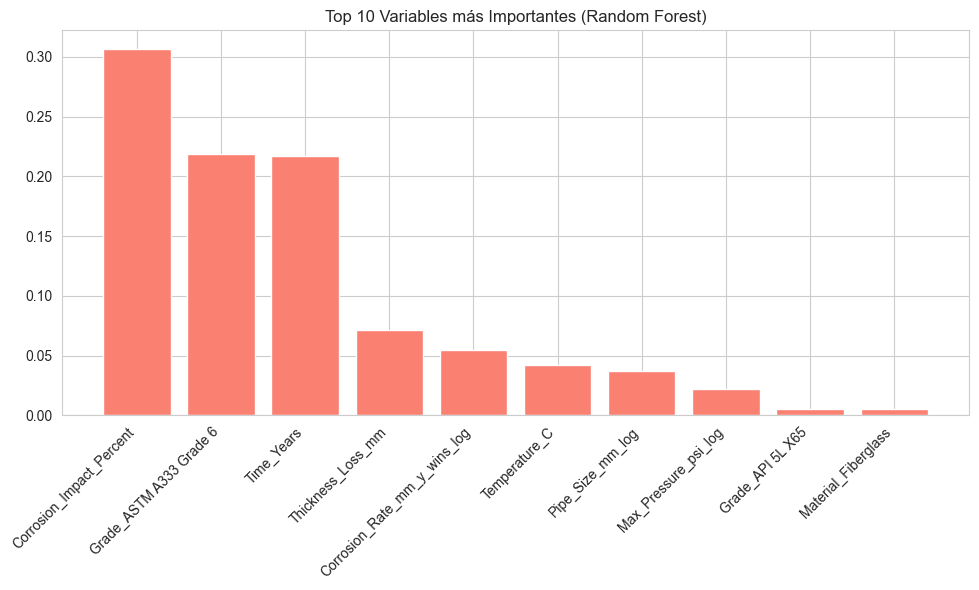

In [4]:
# Random Forest
print('\nEntrenando Random Forest...')

from sklearn.ensemble import RandomForestClassifier
rf_model =RandomForestClassifier(n_estimators=150, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)

resultados_rf = evaluar_modelo(rf_model, 
                                X_test, 
                                y_test,
                                'Random Forest')

resultados.append(resultados_rf)

# Feature Importance 
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
top_n = 10

plt.figure(figsize=(10, 6))
plt.title(f"Top {top_n} Variables más Importantes (Random Forest)")
plt.bar(range(top_n), importances[indices][:top_n], align="center", color='salmon')
plt.xticks(range(top_n), [feature_names[i] for i in indices[:top_n]], rotation=45, ha='right')
plt.tight_layout()
plt.show()


Entrenando XGBoost...

EVALUACIÓN: XGBoost
Accuracy:  0.9550
Recall:    0.9808
F1-Score:  0.9714
ROC-AUC:   0.9894


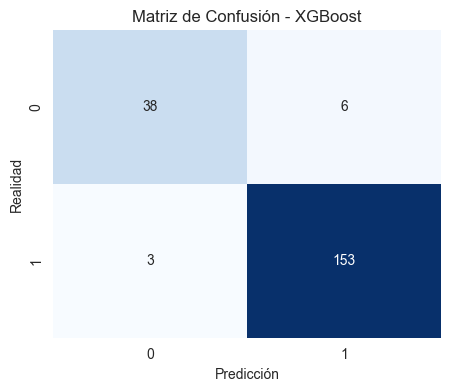

In [5]:
# XGBoost

print("\nEntrenando XGBoost...")

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

resultado_xgb = evaluar_modelo(xgb_model, X_test, y_test, "XGBoost")
resultados.append(resultado_xgb)

## Comparativa de Modelos


COMPARATIVA DE MODELOS


,Accuracy,Recall,F1,AUC
Modelo,,,,
Logistic Regression,0.920,0.961538,0.949367,0.965618
Random Forest,0.935,0.974359,0.958991,0.985140
XGBoost,0.955,0.980769,0.971429,0.989365


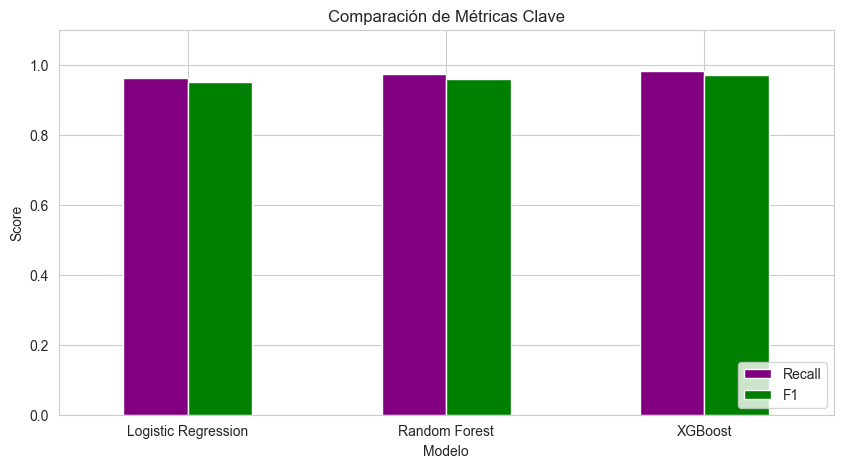

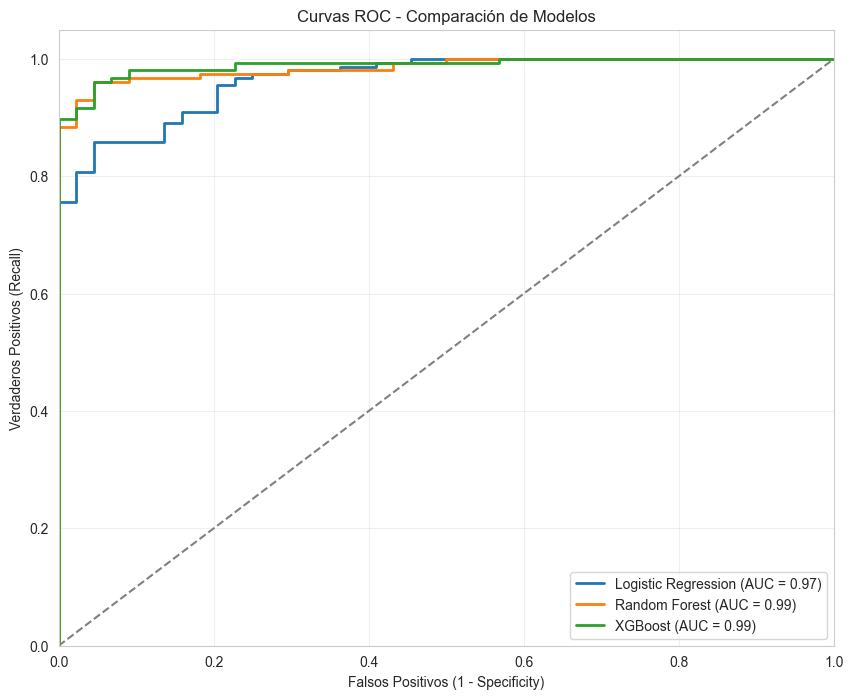

In [6]:
print("\nCOMPARATIVA DE MODELOS")

df_resultados = pd.DataFrame(resultados).set_index('Modelo')
display(df_resultados[['Accuracy', 'Recall', 'F1', 'AUC']])

# --- Gráfico Comparativo ---
df_resultados[['Recall', 'F1']].plot(kind='bar', figsize=(10, 5), color=['purple', 'green'])
plt.title("Comparación de Métricas Clave")
plt.ylim(0, 1.1)
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.show()

# --- Curvas ROC ---
plt.figure(figsize=(10, 8))

for res in resultados:
    fpr, tpr, _ = roc_curve(y_test, res['y_prob'])
    plt.plot(fpr, tpr, lw=2, label=f"{res['Modelo']} (AUC = {res['AUC']:.2f})")

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Falsos Positivos (1 - Specificity)')
plt.ylabel('Verdaderos Positivos (Recall)')
plt.title('Curvas ROC - Comparación de Modelos')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

### Comprobar Overfitting y Underfitting

In [7]:
resultados = evaluar_overfitting(
    model=lr_model,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    nombre_modelo="Regresión Logística"
)


 Evaluación de Overfitting: Regresión Logística
--------------------------------------------------
Accuracy_train: 0.9350
Accuracy_test: 0.9200
Recall_train: 0.9648
Recall_test: 0.9615
F1_train: 0.9587
F1_test: 0.9494
AUC_train: 0.9766
AUC_test: 0.9656
--------------------------------------------------

🔍 Diagnóstico:
 Buen equilibrio: el modelo generaliza bien.


In [8]:
resultados = evaluar_overfitting(
    model=rf_model,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    nombre_modelo="Random Forest"
)


 Evaluación de Overfitting: Random Forest
--------------------------------------------------
Accuracy_train: 1.0000
Accuracy_test: 0.9350
Recall_train: 1.0000
Recall_test: 0.9744
F1_train: 1.0000
F1_test: 0.9590
AUC_train: 1.0000
AUC_test: 0.9851
--------------------------------------------------

🔍 Diagnóstico:
 Buen equilibrio: el modelo generaliza bien.


In [9]:
resultados = evaluar_overfitting(
    model=xgb_model,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test,
    nombre_modelo="XGBoost"
)


 Evaluación de Overfitting: XGBoost
--------------------------------------------------
Accuracy_train: 1.0000
Accuracy_test: 0.9550
Recall_train: 1.0000
Recall_test: 0.9808
F1_train: 1.0000
F1_test: 0.9714
AUC_train: 1.0000
AUC_test: 0.9894
--------------------------------------------------

🔍 Diagnóstico:
 Buen equilibrio: el modelo generaliza bien.


### Cross Validation

In [10]:
print("Cross Validation (Estabilidad de los Modelos)")
print("Evaluacion con 5 folds para cada modelo...")

# Lista de modelos a evaluar
modelos_cv = [
    ('Logistic Regression', lr_model),
    ('Random Forest', rf_model),
    ('XGBoost', xgb_model)
]

# Dicionario para guardar resultados del CV
resultasdos_cv = []

for nombre, modelo in modelos_cv:
    # F1 Score para medir el balance, no solo accuracy
    scores = cross_val_score(modelo, X_train, y_train, cv=5, scoring='f1')

    mean_score = scores.mean()
    std_score = scores.std()

    resultasdos_cv.append({
        'Modelo' : nombre,
        'F1 CV Promedio' : mean_score,
        'Desviacion Estandar' : std_score
    })
    
    print(f"\n{nombre}:")
    print(f"   Scores individuales: {scores}")
    print(f"   Promedio: {mean_score:.4f} (+/- {std_score:.4f})")
    
    # Diagnóstico rápido
    if std_score < 0.05:
        print("   - Modelo muy estable.")
    else:
        print("   - Modelo con alta varianza (inestable).")


Cross Validation (Estabilidad de los Modelos)
Evaluacion con 5 folds para cada modelo...

Logistic Regression:
   Scores individuales: [0.953125   0.95967742 0.96356275 0.944      0.96062992]
   Promedio: 0.9562 (+/- 0.0070)
   - Modelo muy estable.

Random Forest:
   Scores individuales: [0.96850394 0.96385542 0.968      0.96442688 0.96470588]
   Promedio: 0.9659 (+/- 0.0019)
   - Modelo muy estable.

XGBoost:
   Scores individuales: [0.97619048 0.98387097 0.97959184 0.99206349 0.96825397]
   Promedio: 0.9800 (+/- 0.0079)
   - Modelo muy estable.


In [11]:
# Tabla comparativa
df_cv = pd.DataFrame(resultasdos_cv)
print("\nResumen de Estabilidad:")
display(df_cv)


Resumen de Estabilidad:


,Modelo,F1 CV Promedio,Desviacion Estandar
0,Logistic Regression,0.956199,0.006989
1,Random Forest,0.965898,0.001948
2,XGBoost,0.979994,0.007914


### VISUALIZACIÓNES (Predicciones de Random Forest) 


Generando Análisis de Fronteras (PCA vs FÍSICA)...
Top 2 Variables Físicas: ['Corrosion_Impact_Percent', 'Grade_ASTM A333 Grade 6']


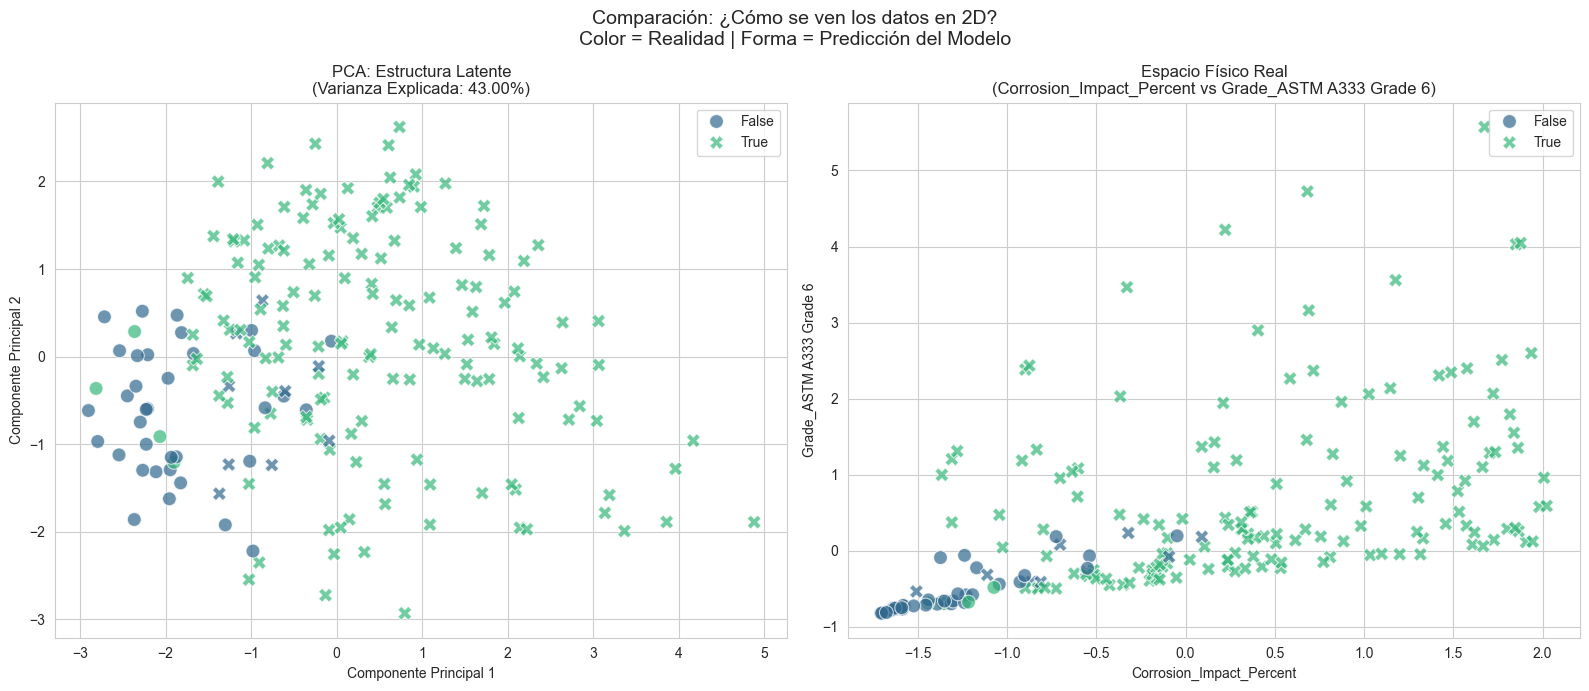

- Si el PCA separa bien los colores, el problema es 'matemáticamente simple'.
- Si las Top 2 Features separan bien, el problema es 'físicamente explicable'.


In [12]:
# VISUALIZACIÓNES(PCA vs FÍSICA)

print("\nGenerando Análisis de Fronteras (PCA vs FÍSICA)...")

# PCA (visión Matemática)
pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test) 

# TOP 2 FEATURES (La visión Física)
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
top_2_cols = [feature_names[i] for i in indices[:2]]
print(f"Top 2 Variables Físicas: {top_2_cols}")

X_test_fisica = X_test[top_2_cols].values

# GENERACIÓN DE GRÁFICOS
fig, axes = plt.subplots(1, 2, figsize=(16, 7))
y_test_flat = y_test.values.ravel() 
y_pred_flat = rf_model.predict(X_test)

# Gráfico PCA
sns.scatterplot(
    x=X_test_pca[:, 0], y=X_test_pca[:, 1], 
    hue=y_test_flat,      
    style=y_pred_flat,    
    palette='viridis', ax=axes[0], s=100, alpha=0.7
)
axes[0].set_title(f"PCA: Estructura Latente\n(Varianza Explicada: {sum(pca.explained_variance_ratio_):.2%})")
axes[0].set_xlabel("Componente Principal 1")
axes[0].set_ylabel("Componente Principal 2")

# Gráfico Físico (Top 2 Features)
sns.scatterplot(
    x=X_test_fisica[:, 0], y=X_test_fisica[:, 1], 
    hue=y_test_flat,      
    style=y_pred_flat,    
    palette='viridis', ax=axes[1], s=100, alpha=0.7
)
axes[1].set_title(f"Espacio Físico Real\n({top_2_cols[0]} vs {top_2_cols[1]})")
axes[1].set_xlabel(top_2_cols[0])
axes[1].set_ylabel(top_2_cols[1])

plt.suptitle("Comparación: ¿Cómo se ven los datos en 2D?\nColor = Realidad | Forma = Predicción del Modelo", fontsize=14)
plt.tight_layout()
plt.show()

print("- Si el PCA separa bien los colores, el problema es 'matemáticamente simple'.")
print("- Si las Top 2 Features separan bien, el problema es 'físicamente explicable'.")

#### __La "Guía de Lectura" del gráfico:__
__Formas (Lo que dice el Modelo):__

* Círculo (Punto/o): El modelo dijo "No Falla" (0).

* Cruz (X): El modelo dijo "SÍ Falla" (1).

__Colores (La Verdad):__

* Azul: El caño estaba Sano en la realidad.

* Verde (según paleta): El caño estaba Roto en la realidad.

In [13]:
# Guardado de modelos

# Crear carpeta si no existe
if not os.path.exists('../models'):
    os.makedirs('../models')

print("Guardando modelos para la App...")

# 1. El Baseline
joblib.dump(lr_model, '../models/logistic_model.pkl')
print(f"\nRegresión Logística guardada. (Accuracy: {resultados_lr['Accuracy']:.4f})")

# 2. El Robusto
joblib.dump(rf_model, '../models/random_forest.pkl')
print(f"Random Forest guardado. (Accuracy: {resultados_rf['Accuracy']:.4f})")

# 3. El Potente
joblib.dump(xgb_model, '../models/xgboost.pkl')
print(f"XGBoost guardado. (Accuracy: {resultado_xgb['Accuracy']:.4f})")

print("\n¡Todo listo! Los archivos .pkl ya están esperando a Streamlit.")

Guardando modelos para la App...

Regresión Logística guardada. (Accuracy: 0.9200)
Random Forest guardado. (Accuracy: 0.9350)
XGBoost guardado. (Accuracy: 0.9550)

¡Todo listo! Los archivos .pkl ya están esperando a Streamlit.


### Selección de Modelos para Producción

Tras evaluar el rendimiento, la estabilidad y la interpretabilidad de los candidatos, he decidido **conservar y desplegar los tres modelos** en la aplicación final.
Dado las buenos resultados en las metricas en (gran medida por el tamaño de dataset), no es necesario hace una busqueda optima de hiperparametros.

Cada modelo aporta un valor distinto al usuario final:
### 1. Regresión Logística (Baseline)
* **Rol:** Modelo de referencia y máxima interpretabilidad.
* **Por qué se queda:** Actúa como el "piso" de rendimiento. Permite al usuario ver cómo un enfoque lineal simple se compara con algoritmos complejos. 
* **Ideal para:** Auditoría rápida y explicaciones sencillas de relaciones directas (ej: "a mayor presión, mayor riesgo").

### 2. Random Forest (Estándar Robusto)
* **Rol:** Modelo de confianza.
* **Por qué se queda:** Captura relaciones no lineales y complejas (interacciones entre variables) sin riesgo alto de *overfitting*.


### 3. XGBoost (Alto Rendimiento)
* **Rol:** Potencia pura.
* **Por qué se queda:** Representa la vanguardia en datos tabulares. Aunque requiere más cuidado para evitar el sobreajuste, ofrece la capacidad de exprimir ese % extra de precisión en situaciones críticas.
* **Ideal para:** Escenarios donde la precisión (detectar cada falla posible) es más importante que la simplicidad del modelo.